    comparativa datasets notebook
    

In [47]:
import os
import re
import warnings
import pandas as pd
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# =========================
# 1) Carpeta con los datos
# =========================
base_path = Path.cwd().parent / "data/data_comparativa"

# =========================
# 2) Listado de CSVs (.csv y .csv.gz)
# =========================
csv_files = []
for pattern in ("*.csv", "*.csv.gz"):
    csv_files.extend(base_path.glob(pattern))
if not csv_files:
    raise FileNotFoundError(f"No se encontraron archivos CSV en {base_path}")

# =========================
# Helper: extraer fecha del nombre del archivo
# - Priorizamos una fecha al FINAL del nombre (antes de la extensión), p. ej.:
#     consulta_03_30dias_2025-08-21.csv   -> 2025-08-21
#     consulta_02_2025-08-27.csv          -> 2025-08-27
# - Si hay varias fechas en el nombre, usamos la ÚLTIMA coincidencia.
# - Devuelve una tupla (granularidad, clave, datetime) donde:
#     granularidad ∈ {"day","month","year"}
#     clave        ∈ {"YYYY-MM-DD", "YYYY-MM", "YYYY"}
# =========================
def extract_date_from_name(name: str):
    stem = Path(name).stem.lower()

    # Listas de patrones (DAY primero, luego MONTH, luego YEAR)
    # Buscamos TODAS y nos quedamos con la ÚLTIMA
    patterns_day = [
        r"(20\d{2})[-_]?([01]\d)[-_]?([0-3]\d)$",           # YYYY-MM-DD / YYYY_MM_DD / YYYYMMDD al final
        r"(20\d{2})[-_]?([01]\d)[-_]?([0-3]\d)\b",          # en cualquier parte
        r"([0-3]\d)[-_]([01]\d)[-_](20\d{2})$",
        r"([0-3]\d)[-_]([01]\d)[-_](20\d{2})\b",
    ]
    patterns_month = [
        r"(20\d{2})[-_]?([01]\d)$",                         # YYYY-MM / YYYYMM al final
        r"(20\d{2})[-_]?([01]\d)\b",
    ]
    patterns_year = [
        r"(20\d{2})$",
        r"(20\d{2})\b",
    ]

    def find_last(patterns, builder):
        last = None
        for pat in patterns:
            for m in re.finditer(pat, stem):
                try:
                    dt, key = builder(m)
                    last = (dt, key)
                except ValueError:
                    continue
        return last

    # Builders
    def build_day(m):
        # Puede venir como YYYY MM DD o DD MM YYYY según patrón
        g = m.groups()
        if len(g) == 3:
            # Probamos dos órdenes
            try:
                y, mo, d = int(g[0]), int(g[1]), int(g[2])
            except ValueError:
                y, mo, d = None, None, None
            if y and 2000 <= y <= 2099:
                dt = datetime(y, mo, d)
                return dt, dt.strftime("%Y-%m-%d")
            # Alternativa: DD-MM-YYYY
            d, mo, y = int(g[0]), int(g[1]), int(g[2])
            dt = datetime(y, mo, d)
            return dt, dt.strftime("%Y-%m-%d")
        raise ValueError

    def build_month(m):
        y, mo = int(m.group(1)), int(m.group(2))
        dt = datetime(y, mo, 1)
        return dt, dt.strftime("%Y-%m")

    def build_year(m):
        y = int(m.group(1))
        dt = datetime(y, 1, 1)
        return dt, str(y)

    # Prioridad: día > mes > año (cada uno toma la última coincidencia)
    last_day = find_last(patterns_day, build_day)
    if last_day:
        dt, key = last_day
        return ("day", key, dt)

    last_month = find_last(patterns_month, build_month)
    if last_month:
        dt, key = last_month
        return ("month", key, dt)

    last_year = find_last(patterns_year, build_year)
    if last_year:
        dt, key = last_year
        return ("year", key, dt)

    return None

# =========================
# 3) Cargar TODOS los CSV agrupados por fecha EN NOMBRE
#    (Ignoramos archivos sin fecha detectable en el nombre)
# =========================
dfs_por_fecha_tmp = defaultdict(list)
archivos_sin_fecha = []

for fp in csv_files:
    info = extract_date_from_name(fp.name)
    if info is None:
        archivos_sin_fecha.append(fp.name)
        continue
    gran, date_key, _ = info
    df = pd.read_csv(fp, low_memory=False)
    dfs_por_fecha_tmp[date_key].append(df)

if archivos_sin_fecha:
    warnings.warn(
        "Se ignoraron archivos sin fecha en el nombre (no se usa mtime):\n  - " +
        "\n  - ".join(archivos_sin_fecha)
    )

# =========================
# 4) Concatenar si hay varios archivos para la misma fecha
# =========================
dfs_por_fecha = {}
for date_key, parts in dfs_por_fecha_tmp.items():
    if len(parts) == 1:
        dfs_por_fecha[date_key] = parts[0]
    else:
        dfs_por_fecha[date_key] = pd.concat(parts, ignore_index=True)

# =========================
# 5) Mostrar resumen
# =========================
print("✅ Fechas detectadas en nombre y tamaños:")
for k in sorted(dfs_por_fecha):
    print(f"  - {k}: {dfs_por_fecha[k].shape[0]:,} filas x {dfs_por_fecha[k].shape[1]} cols")

# =========================
# 6) Elegir extremos por FECHA EN NOMBRE (no mtime)
#    Admitimos claves 'YYYY', 'YYYY-MM', 'YYYY-MM-DD'
# =========================
def parse_key_to_datetime(key: str) -> datetime:
    if re.fullmatch(r"\d{4}-\d{2}-\d{2}", key):
        return datetime.strptime(key, "%Y-%m-%d")
    if re.fullmatch(r"\d{4}-\d{2}", key):
        return datetime.strptime(key, "%Y-%m")
    if re.fullmatch(r"\d{4}", key):
        return datetime.strptime(key, "%Y")
    raise ValueError(f"Formato de clave de fecha no soportado: {key}")

if not dfs_por_fecha:
    raise RuntimeError("No hay archivos válidos con fecha en el nombre.")

fechas_ordenadas = sorted(dfs_por_fecha.keys(), key=parse_key_to_datetime)
fecha_oldest = fechas_ordenadas[0]
fecha_latest = fechas_ordenadas[-1]

def varname_for_key(key: str) -> str:
    return f"df_{key.replace('-', '_')}"

globals()[varname_for_key(fecha_oldest)] = dfs_por_fecha[fecha_oldest]
globals()[varname_for_key(fecha_latest)] = dfs_por_fecha[fecha_latest]

print(f"\n📂 Más antiguo (por nombre): {fecha_oldest} -> variable creada: {varname_for_key(fecha_oldest)} "
      f"({dfs_por_fecha[fecha_oldest].shape[0]:,} x {dfs_por_fecha[fecha_oldest].shape[1]})")
print(f"📂 Más reciente (por nombre): {fecha_latest} -> variable creada: {varname_for_key(fecha_latest)} "
      f"({dfs_por_fecha[fecha_latest].shape[0]:,} x {dfs_por_fecha[fecha_latest].shape[1]})")

# =========================
# 7) Cargar Excel validado como DFDatosValidados (y normalizar ranch_name)
# =========================
excel_file = base_path / "datos_validados.xlsx"

def asegurar_col_ranch(df, preferidas=("ranch_name","RanchName","RanchId","ranch","ganaderia","Ganadería")):
    for c in preferidas:
        if c in df.columns:
            return c
    return None

if excel_file.exists():
    DFDatosValidados = pd.read_excel(excel_file)
    col_ranch = asegurar_col_ranch(DFDatosValidados)
    if col_ranch is None:
        raise KeyError("No encuentro columna de ganadería en DFDatosValidados (busqué ranch_name/RanchName/RanchId/ranch/ganaderia/Ganadería).")
    if col_ranch != "ranch_name":
        DFDatosValidados = DFDatosValidados.rename(columns={col_ranch: "ranch_name"})
    print(f"✅ DFDatosValidados cargado: {DFDatosValidados.shape[0]:,} filas x {DFDatosValidados.shape[1]} cols")
else:
    raise FileNotFoundError(f"No se encontró {excel_file}. Crea/coloca el Excel para cargar DFDatosValidados.")

# --- USO ---
# - Accede a cualquier fecha concreta con dfs_por_fecha["YYYY-MM-DD"] (o "YYYY-MM", "YYYY").
# - Variables creadas automáticamente para extremos por nombre:
#     -> df_YYYY_MM_DD / df_YYYY_MM / df_YYYY
# - Archivos sin fecha en el nombre se ignoran (listados en un warning).


✅ Fechas detectadas en nombre y tamaños:
  - 2025-08-21: 9,132 filas x 42 cols
  - 2025-08-27: 9,127 filas x 42 cols

📂 Más antiguo (por nombre): 2025-08-21 -> variable creada: df_2025_08_21 (9,132 x 42)
📂 Más reciente (por nombre): 2025-08-27 -> variable creada: df_2025_08_27 (9,127 x 42)
✅ DFDatosValidados cargado: 16 filas x 11 cols


In [48]:
import pandas as pd
import numpy as np
import re

# ========= util: división segura (evita /0) =========
def pct(num, den):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    return np.where(den > 0, (num / den) * 100.0, np.nan)

def asegurar_col(df, candidatos):
    """Devuelve el nombre EXACTO de la primera columna presente en df de entre 'candidatos' (respetando mayúsculas y comillas)."""
    for c in candidatos:
        if c in df.columns:
            return c
    # intento extra: case-insensitive y tolerando comillas
    low = {str(c).lower(): c for c in df.columns}
    for c in candidatos:
        key = str(c).strip('"').lower()
        # prueba exacta sin comillas
        if key in low:
            return low[key]
        # prueba añadiendo/quitar comillas
        if f'"{key}"' in low:
            return low[f'"{key}"']
    return None

def rename_first_match(df, target_name, candidates):
    """
    Busca la primera columna presente entre 'candidatos' y la renombra a 'target_name'.
    Devuelve (df_mod, found_name) o (df, None) si no encontró.
    """
    col = asegurar_col(df, candidates)
    if col is None:
        return df, None
    if col != target_name:
        df = df.rename(columns={col: target_name})
    return df, col

def normaliza_ranch(df):
    df, found = rename_first_match(df, "ranch_name",
                                   ["ranch_name","RanchName","RanchId","ranch","ganaderia","Ganadería"])
    if found is None:
        raise KeyError("No encuentro columna de ganadería (ranch_name/RanchName/RanchId/ranch/ganaderia/Ganadería).")
    return df

def normaliza_device(df):
    df, found = rename_first_match(df, "device_id", ["device_id","DeviceId","dispositivo","id_device","device"])
    if found is None:
        # si no hay device_id, crea nulo (pero avisamos)
        print("⚠️  No hay 'device_id' en el DataFrame; se creará vacío (podría dar n_dispositivos=0).")
        df = df.copy()
        df["device_id"] = np.nan
    return df

def diagnostico_columnas_detectadas(mapeo_detectado):
    if not mapeo_detectado:
        return
    print("🔎 Columnas detectadas y mapeadas:")
    for estandar, alias in mapeo_detectado.items():
        print(f"   - {estandar}  <=  {alias}")

# ========= construcción por GANADERÍA (robusta a alias y sin sobreconteo) =========
def construir_df_ganaderias_desde_raw(df: pd.DataFrame) -> pd.DataFrame:
    """
    Toma el DF detallado (varias filas por device_id posibles) y devuelve
    la tabla agregada por ganadería con métricas y %,
    normalizando alias y evitando sobreconteo.
    """
    if df is None or df.empty:
        return pd.DataFrame()

    df = df.copy()

    # --- Normalizaciones básicas ---
    df = normaliza_ranch(df)
    df = normaliza_device(df)

    # --- Mapeo de alias a nombres ESTÁNDAR (los de consulta 2) ---
    alias_map = {
        # esperados por día
        "Mensajes esperados (detallado)": [
            'Mensajes esperados (detallado)', '"Mensajes esperados (detallado)"',
            'mensajes_esperados', 'mensajes_esperados_por_dia', 'mensajes_esperados_por_día',
            'UplinksPerDay', 'mensajes_esperados_detallado'
        ],
        # recibidos
        "Mensajes recibidos (n)": [
            'Mensajes recibidos (n)', '"Mensajes recibidos (n)"',
            'mensajes_recibidos', 'Promedio mensajes recibidos/día', 'recibidos_n'
        ],
        # con GPS
        "Mensaje con posición GPS (n)": [
            'Mensaje con posición GPS (n)', '"Mensaje con posición GPS (n)"',
            'mensajes_con_gps', 'Promedio mensajes con GPS/día', 'con_gps_n'
        ],
        # válidas
        "Posición GPS válida (n)": [
            'Posición GPS válida (n)', '"Posición GPS válida (n)"',
            'posiciones_validas', 'Promedio posiciones válidas/día', 'validas_n'
        ],
        # baja precisión
        "Baja precisión (n)": [
            'Baja precisión (n)', '"Baja precisión (n)"',
            'baja_precision', 'Promedio baja precisión/día', 'baja_precision_n'
        ],
        # no válidas
        "Posición GPS no válida (n)": [
            'Posición GPS no válida (n)', '"Posición GPS no válida (n)"',
            'posiciones_no_validas', 'Promedio no válidas/día', 'no_validas_n'
        ],
        # no válida calidad gps
        "No válida por calidad GPS (n)": [
            'No válida por calidad GPS (n)', '"No válida por calidad GPS (n)"',
            'no_valida_calidad', 'Promedio no válida por calidad GPS/día', 'no_valida_calidad_gps_n'
        ],
        # no válida velocidad
        "No válida por filtro velocidad (n)": [
            'No válida por filtro velocidad (n)', '"No válida por filtro velocidad (n)"',
            'no_valida_velocidad', 'Promedio no válida por velocidad/día', 'no_valida_filtro_velocidad_n'
        ],
    }

    mapeo_detectado = {}
    for estandar, candidatos in alias_map.items():
        df, found = rename_first_match(df, estandar, candidatos)
        if found is not None:
            mapeo_detectado[estandar] = found

    # Diagnóstico útil en consola
    diagnostico_columnas_detectadas(mapeo_detectado)

    # Comprobación estricta de columnas mínimas
    base_necesarias = [
        "Mensajes esperados (detallado)",
        "Mensajes recibidos (n)",
        "Mensaje con posición GPS (n)",
        "Posición GPS válida (n)",
        "Baja precisión (n)",
        "Posición GPS no válida (n)",
        "No válida por calidad GPS (n)",
        "No válida por filtro velocidad (n)",
    ]
    faltantes = [c for c in base_necesarias if c not in df.columns]
    if faltantes:
        # Fallamos claro para no propagar 0s silenciosos
        raise KeyError(
            "Faltan columnas necesarias en el DataFrame de entrada.\n"
            f"Faltan: {faltantes}\n"
            "Revisa que el CSV tenga los encabezados esperados o añade sus alias al 'alias_map'."
        )

    # Asegurar numérico (si venían como string)
    for c in base_necesarias:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # ---------- (1) CONSOLIDAR por (ranch_name, device_id) ----------
    by_dev = (
        df.groupby(["ranch_name","device_id"], dropna=False)[base_necesarias]
          .sum(min_count=1)
          .reset_index()
    )

    # ---------- (2) Recalcular OK por DISPOSITIVO con consolidados ----------
    ok_col = "Dispositivo OK (≥60% válidas vs esperadas)"
    den = by_dev["Mensajes esperados (detallado)"].astype(float)
    num = by_dev["Posición GPS válida (n)"].astype(float)
    pct_valid_vs_expected = np.where(den > 0, (num / den) * 100.0, np.nan)
    by_dev[ok_col] = np.where(~np.isnan(pct_valid_vs_expected), pct_valid_vs_expected >= 60.0, False)
    by_dev[ok_col] = by_dev[ok_col].fillna(False).astype(bool)

    # ---------- (3) AGREGADO final por GANADERÍA ----------
    agr_cols = {
        "device_id": "nunique",
        "Mensajes esperados (detallado)": "sum",
        "Mensajes recibidos (n)": "sum",
        "Mensaje con posición GPS (n)": "sum",
        "Posición GPS válida (n)": "sum",
        "Baja precisión (n)": "sum",
        "Posición GPS no válida (n)": "sum",
        "No válida por calidad GPS (n)": "sum",
        "No válida por filtro velocidad (n)": "sum",
        ok_col: "sum",  # suma de flags ya por dispositivo
    }

    agg = (
        by_dev.groupby("ranch_name", dropna=False)
              .agg(agr_cols)
              .rename(columns={
                  "device_id": "n_dispositivos",
                  ok_col: "dispositivos_ok",
              })
              .reset_index()
    )

    # ---------- (4) Porcentajes de calidad a nivel GANADERÍA ----------
    def add_pct(target_df, num_col, den_col, out_col):
        if num_col in target_df.columns and den_col in target_df.columns:
            target_df[out_col] = pct(target_df[num_col], target_df[den_col])
        return target_df

    agg = add_pct(agg, "Mensajes recibidos (n)",           "Mensajes esperados (detallado)", "Mensajes recibidos (%)")
    agg = add_pct(agg, "Mensaje con posición GPS (n)",     "Mensajes recibidos (n)",         "Mensaje con posición GPS (%)")
    agg = add_pct(agg, "Posición GPS válida (n)",          "Mensajes recibidos (n)",         "Posición GPS válida (%)")
    agg = add_pct(agg, "Baja precisión (n)",               "Posición GPS válida (n)",        "Baja precisión (%)")
    agg = add_pct(agg, "Posición GPS no válida (n)",       "Mensajes recibidos (n)",         "Posición GPS no válida (%)")
    agg = add_pct(agg, "No válida por calidad GPS (n)",    "Posición GPS no válida (n)",     "No válida por calidad GPS (%)")
    agg = add_pct(agg, "No válida por filtro velocidad (n)","Posición GPS no válida (n)",    "No válida por filtro velocidad (%)")

    # % de dispositivos OK y flag global
    agg["% dispositivos OK en ganadería"] = pct(agg["dispositivos_ok"].astype(float),
                                                agg["n_dispositivos"].astype(float))
    agg["Ganadería OK (≥70% dispositivos OK)"] = (agg["% dispositivos OK en ganadería"] >= 70.0)

    # ---------- (5) Orden de columnas ----------
    cols = [
        "ranch_name", "n_dispositivos", "dispositivos_ok", "% dispositivos OK en ganadería",
        "Ganadería OK (≥70% dispositivos OK)",
        "Mensajes esperados (detallado)", "Mensajes recibidos (n)", "Mensajes recibidos (%)",
        "Mensaje con posición GPS (n)", "Mensaje con posición GPS (%)",
        "Posición GPS válida (n)", "Posición GPS válida (%)",
        "Baja precisión (n)", "Baja precisión (%)",
        "Posición GPS no válida (n)", "Posición GPS no válida (%)",
        "No válida por calidad GPS (n)", "No válida por calidad GPS (%)",
        "No válida por filtro velocidad (n)", "No válida por filtro velocidad (%)",
    ]
    cols = [c for c in cols if c in agg.columns]
    agg = agg[cols].sort_values("% dispositivos OK en ganadería", ascending=False, na_position="last")

    return agg

# ========= Ejecutar PARA CADA FECHA disponible en dfs_por_fecha =========
df_ganaderias_por_fecha = {}
for fecha_key, df_raw in sorted(dfs_por_fecha.items()):
    out = construir_df_ganaderias_desde_raw(df_raw)
    varname = f"df_ganaderias_{fecha_key.replace('-', '_')}"
    globals()[varname] = out
    df_ganaderias_por_fecha[fecha_key] = out
    print(f"✅ creado {varname}: {out.shape[0]} filas x {out.shape[1]} cols")


🔎 Columnas detectadas y mapeadas:
   - Mensajes esperados (detallado)  <=  "Mensajes esperados (detallado)"
   - Mensajes recibidos (n)  <=  "Mensajes recibidos (n)"
   - Mensaje con posición GPS (n)  <=  "Mensaje con posición GPS (n)"
   - Posición GPS válida (n)  <=  "Posición GPS válida (n)"
   - Baja precisión (n)  <=  "Baja precisión (n)"
   - Posición GPS no válida (n)  <=  "Posición GPS no válida (n)"
   - No válida por calidad GPS (n)  <=  "No válida por calidad GPS (n)"
   - No válida por filtro velocidad (n)  <=  "No válida por filtro velocidad (n)"
✅ creado df_ganaderias_2025_08_21: 490 filas x 20 cols
🔎 Columnas detectadas y mapeadas:
   - Mensajes esperados (detallado)  <=  Mensajes esperados (detallado)
   - Mensajes recibidos (n)  <=  Mensajes recibidos (n)
   - Mensaje con posición GPS (n)  <=  Mensaje con posición GPS (n)
   - Posición GPS válida (n)  <=  Posición GPS válida (n)
   - Baja precisión (n)  <=  Baja precisión (n)
   - Posición GPS no válida (n)  <=  Posici

In [49]:
import pandas as pd
import numpy as np
import re

def asegurar_col(df, candidatos):
    for c in candidatos:
        if c in df.columns:
            return c
    low = {str(c).lower(): c for c in df.columns}
    for c in candidatos:
        key = str(c).strip('"').lower()
        if key in low:
            return low[key]
    return None

def normaliza_ranch(df):
    col = asegurar_col(df, ["ranch_name","RanchName","RanchId","ranch","ganaderia","Ganadería"])
    if col is None:
        raise KeyError("No encuentro columna de ganadería (ranch_name/RanchName/RanchId/ranch/ganaderia/Ganadería).")
    if col != "ranch_name":
        df = df.rename(columns={col: "ranch_name"})
    return df

def parse_key_to_datetime(key: str) -> pd.Timestamp:
    if re.fullmatch(r"\d{4}-\d{2}-\d{2}", key):
        return pd.to_datetime(key, format="%Y-%m-%d")
    if re.fullmatch(r"\d{4}-\d{2}", key):
        return pd.to_datetime(key, format="%Y-%m")
    if re.fullmatch(r"\d{4}", key):
        return pd.to_datetime(key, format="%Y")
    raise ValueError(f"Formato de clave de fecha no soportado: {key}")

def build_validated_comparison(DFDatosValidados: pd.DataFrame,
                               df_ganaderias_por_fecha: dict[str, pd.DataFrame],
                               fecha_1: str | None = None,
                               fecha_2: str | None = None) -> pd.DataFrame:
    """
    Une al DF validado TODAS sus columnas + la 'Posición GPS válida (%)' de dos cortes temporales,
    añade el 'n_dispositivos' del dataset más reciente, y calcula la diferencia.
    """
    if not df_ganaderias_por_fecha:
        raise ValueError("df_ganaderias_por_fecha está vacío.")

    dv = normaliza_ranch(DFDatosValidados).copy()

    fechas = sorted(df_ganaderias_por_fecha.keys(), key=parse_key_to_datetime)
    if len(fechas) < 2 and (fecha_1 is None or fecha_2 is None):
        raise ValueError("Se necesitan al menos dos fechas en df_ganaderias_por_fecha o especificar fecha_1 y fecha_2.")

    if fecha_1 is None or fecha_2 is None:
        fecha_2 = fechas[-1]
        fecha_1 = fechas[-2]

    if fecha_1 not in df_ganaderias_por_fecha or fecha_2 not in df_ganaderias_por_fecha:
        raise KeyError(f"Fechas no encontradas. Disponibles: {fechas}")

    col_target = "Posición GPS válida (%)"
    col_devices = "n_dispositivos"

    # ---- función para limpiar cortes ----
    def slice_clean(df_slice: pd.DataFrame, fecha: str, extra_devices=False) -> pd.DataFrame:
        df_slice = normaliza_ranch(df_slice)
        if col_target not in df_slice.columns:
            raise KeyError(f"En el corte {fecha} falta la columna '{col_target}'.")
        cols = ["ranch_name", col_target]
        if extra_devices and col_devices in df_slice.columns:
            cols.append(col_devices)
        out = df_slice[cols].copy()
        out[col_target] = pd.to_numeric(out[col_target], errors="coerce")
        if col_devices in out.columns:
            out[col_devices] = pd.to_numeric(out[col_devices], errors="coerce")
        out = out.groupby("ranch_name", dropna=False).mean(numeric_only=True).reset_index()
        rename_map = {col_target: f"{col_target} [{fecha}]"}
        if extra_devices and col_devices in out.columns:
            rename_map[col_devices] = f"{col_devices} [{fecha}]"
        out = out.rename(columns=rename_map)
        return out

    g1 = slice_clean(df_ganaderias_por_fecha[fecha_1], fecha_1)
    g2 = slice_clean(df_ganaderias_por_fecha[fecha_2], fecha_2, extra_devices=True)

    out = dv.merge(g1, on="ranch_name", how="left").merge(g2, on="ranch_name", how="left")

    col1 = f"{col_target} [{fecha_1}]"
    col2 = f"{col_target} [{fecha_2}]"
    col_dev2 = f"{col_devices} [{fecha_2}]"

    out["Diferencia (%)"] = (out[col2] - out[col1]).round(2)

    def format_signed(x):
        if pd.isna(x):
            return np.nan
        sign = "+" if x > 0 else ""
        val = int(x) if float(x).is_integer() else round(float(x), 2)
        return f"{sign}{val}%"

    out["Δ"] = out["Diferencia (%)"].apply(format_signed)

    # Orden final: todas las originales del validado + añadidos
    cols_base = list(dv.columns)
    extra_cols = [col1, col2, col_dev2, "Diferencia (%)", "Δ"]
    out = out[cols_base + [c for c in extra_cols if c in out.columns]]

    return out

# ===== ejemplo de uso =====
df_comparativa_validado = build_validated_comparison(
    DFDatosValidados,
    df_ganaderias_por_fecha,
    fecha_1="2025-08-21",
    fecha_2="2025-08-27"
)


In [46]:
from pathlib import Path
import pandas as pd
import os
import openpyxl


def desktop_path():
    return Path(os.path.expandvars(r"%USERPROFILE%")) / "Desktop"

desktop = desktop_path()
ruta_xlsx = desktop / f"df_comparativa_validado{pd.Timestamp.now():%Y%m%d_%H%M%S}.xlsx"

# Sin especificar engine
with pd.ExcelWriter(ruta_xlsx) as writer:
    df_comparativa_validado.to_excel(writer, index=False, sheet_name="datos")

print(f"✅ Excel guardado en: {ruta_xlsx}")


✅ Excel guardado en: C:\Users\usuario\Desktop\df_comparativa_validado20250828_222137.xlsx


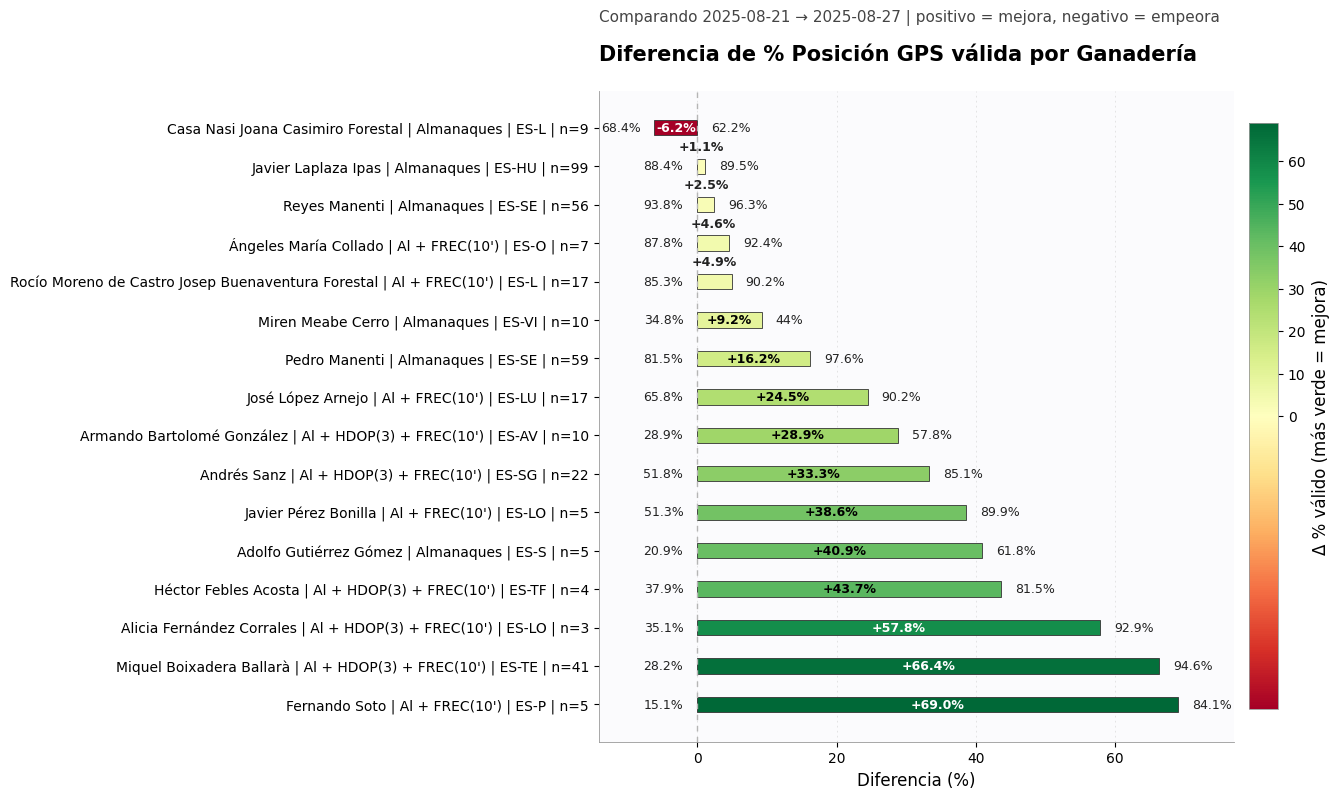

In [56]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ======================
# 1) Preparación de datos
# ======================
df_plot = df_comparativa_validado.copy()

col_target_base = "Posición GPS válida (%)"
pct_cols = [c for c in df_plot.columns if c.startswith(col_target_base)]
if len(pct_cols) < 2:
    raise KeyError("No encuentro al menos dos columnas de '% válido' en df_comparativa_validado.")

def parse_bracket_date(col_name: str) -> pd.Timestamp:
    m = re.search(r"\[(\d{4}(?:-\d{2})?(?:-\d{2})?)\]\s*$", col_name)
    if not m:
        return pd.Timestamp.min
    raw = m.group(1)
    for fmt in ("%Y-%m-%d", "%Y-%m", "%Y"):
        try:
            return pd.to_datetime(raw, format=fmt)
        except Exception:
            pass
    return pd.Timestamp.min

pct_cols_sorted = sorted(pct_cols, key=parse_bracket_date)
fecha_1_col, fecha_2_col = pct_cols_sorted[0], pct_cols_sorted[-1]

# n_dispositivos del dataset más reciente (si existe)
devices_cols = [c for c in df_plot.columns if c.startswith("n_dispositivos")]
col_devices_recent = None
if devices_cols:
    m2 = re.search(r"\[(.+)\]\s*$", fecha_2_col)
    if m2:
        tag2 = m2.group(1)
        cand = [c for c in devices_cols if c.endswith(f"[{tag2}]")]
        col_devices_recent = cand[0] if cand else devices_cols[-1]
    else:
        col_devices_recent = devices_cols[-1]

col_ranch = "ranch_name"
col_cmd   = "Comandos Finales" if "Comandos Finales" in df_plot.columns else None
col_reg   = "Region" if "Region" in df_plot.columns else None

for c in [fecha_1_col, fecha_2_col]:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

if "Diferencia (%)" not in df_plot.columns:
    df_plot["Diferencia (%)"] = (df_plot[fecha_2_col] - df_plot[fecha_1_col]).round(2)

def make_y_label(row):
    parts = [str(row[col_ranch])]
    if col_cmd: parts.append(str(row[col_cmd]))
    if col_reg: parts.append(str(row[col_reg]))
    if col_devices_recent and pd.notna(row.get(col_devices_recent, np.nan)):
        try:
            parts.append(f"n={int(row[col_devices_recent])}")
        except Exception:
            pass
    return " | ".join(parts)

df_plot["label_y"] = df_plot.apply(make_y_label, axis=1)

TOP_N = 20   # cambialo si quieres todas
df_top = df_plot.sort_values("Diferencia (%)", ascending=False).head(TOP_N).reset_index(drop=True)

# ======================
# 2) Estilo
# ======================
plt.rcParams.update({
    "axes.edgecolor": "#999999",
    "axes.linewidth": 0.6,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
})

cmap = mpl.cm.RdYlGn
diff_vals = df_top["Diferencia (%)"].astype(float).to_numpy()
# ---- RANGO REAL (no fijo) con punto neutro en 0
vmin, vmax = float(np.nanmin(diff_vals)), float(np.nanmax(diff_vals))
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

# ======================
# 3) Figura
# ======================
n = len(df_top)
y_positions = np.arange(n) * 2.0
bar_height = 0.8

fig, ax = plt.subplots(figsize=(15, max(8, n * 0.55)))

# Fondo y línea 0
ax.set_facecolor("#FBFBFD")
ax.axvline(0, linestyle=(0, (4, 4)), color="#B5B5B5", linewidth=1)

# Barras
colors = cmap(norm(diff_vals))
bars = ax.barh(
    y_positions,
    diff_vals,
    height=bar_height,
    color=colors,
    edgecolor="#333333",
    linewidth=0.6
)

# Rejilla
ax.xaxis.grid(True, linestyle=(0, (2, 4)), linewidth=0.6, color="#DADADA", alpha=0.85)
ax.set_axisbelow(True)

# Etiquetas Y
ax.set_yticks(y_positions)
ax.set_yticklabels(df_top["label_y"])

# Título + subtítulo con MÁS ESPACIO
def extract_tag(c):
    m = re.search(r"\[(.+)\]\s*$", c)
    return m.group(1) if m else c

tag1 = extract_tag(fecha_1_col)
tag2 = extract_tag(fecha_2_col)

ax.set_title("Diferencia de % Posición GPS válida por Ganadería",
             pad=22, loc="left", fontsize=15, fontweight="bold")

ax.text(
    0.0, 1.10,  # más alto para que no se pise
    f"Comparando {tag1} → {tag2} | positivo = mejora, negativo = empeora",
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=11, color="#444"
)

ax.set_xlabel("Diferencia (%)")

# Márgenes generosos para etiquetas largas y títulos
fig.subplots_adjust(left=0.40, right=0.91, top=0.82, bottom=0.08)

# ---- Formatos
def fmt_pct(x, decimals=1):
    if pd.isna(x):
        return ""
    x = float(x)
    return f"{int(x)}%" if x.is_integer() else f"{x:.{decimals}f}%"

def contrast_text_color(bg_rgba, threshold=0.55):
    r, g, b, _ = bg_rgba
    # luminancia aproximada
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "white" if lum < threshold else "black"

# Etiquetas: izquierda (fecha1), centro (Δ), derecha (fecha2)
for i, row in df_top.iterrows():
    y = y_positions[i]
    diff = float(row["Diferencia (%)"])
    v1 = row[fecha_1_col]
    v2 = row[fecha_2_col]

    # Centro
    center_x = diff / 2.0
    bar_color = colors[i]
    center_color = contrast_text_color(bar_color, threshold=0.60) if abs(diff) > 6 else "#222"

    if abs(diff) <= 6:
        ax.text(center_x, y + (bar_height * 0.85), f"{diff:+.1f}%",
                ha="center", va="bottom", fontsize=9, fontweight="bold", color=center_color)
    else:
        ax.text(center_x, y, f"{diff:+.1f}%",
                ha="center", va="center", fontsize=9, fontweight="bold", color=center_color)

    # Izquierda: % válido fecha 1
    left_x = min(0.0, diff) - 2.0
    ax.text(left_x, y, fmt_pct(v1), ha="right", va="center", fontsize=9, color="#222")

    # Derecha: % válido fecha 2
    right_x = max(0.0, diff) + 2.0
    ax.text(right_x, y, fmt_pct(v2), ha="left", va="center", fontsize=9, color="#222")

# Límites X con acolchado (basado en rango real)
xpad = max(8, 0.08 * (vmax - vmin if vmax != vmin else 100))
ax.set_xlim(vmin - xpad, vmax + xpad)

# Remata bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Colorbar con rango REAL
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    shrink=0.9,
    pad=0.02
)
cbar.set_label("Δ % válido (más verde = mejora)")

plt.show()

# OPCIONAL: guardar con las fechas en el nombre
# fig.savefig(f"comparativa_validos_{tag1}_vs_{tag2}.png", dpi=200, bbox_inches="tight")
# fig.savefig(f"comparativa_validos_{tag1}_vs_{tag2}.svg", bbox_inches="tight")
